### ReluKANLayer realisation

In [1]:
import matplotlib.pyplot as plt
# from torch_relu_kan import ReLUKANLayer, ReLUKAN
import torch
from torch import nn
import numpy as np


class ReluKANLayer(nn.Module):
    """
    ReluKANLayer class.
    Inspired by github.com/quiqi/relu_kan , arXiv:2406.02075 .
    
    Attributes:
    -----------
        in_features : int
            size of each input sample
        out_features : int
            size of each output sample
        grid : int
            the number of grid intervals in main approximation domain.
        k : int
            characterizes the overcrowding of the basic functions. 
            Each basic function from main approximation domain has intersections with 2*k other basic functions.
        train_ab : bool
            if True, basic functions` starting and ending points are trainable.
        init_base_func_sigm : float > 0
            defines initialization of basic functions` main approximation domain in [-0.5*sigm, 0.5*sigm]
        S : torch.tensor : torch.Size[(out_features, in_features, g+k)]
            starting points of basic functions.
        E : torch.tensor : torch.Size[(out_features, in_features, g+k)]
            ending points of basic functions.
        M : torch.tensor : torch.Size[(out_features, in_features, g+k)]
            multipliers of basic functions.
    """
    def __init__(self, 
                 in_features: int, 
                 out_features: int, 
                 grid: int = 5, 
                 k: int = 3,
                 train_ab: bool = True,
                 init_base_func_sigm: float = 1):
        """
        Initalize a ReLUKANLayer
        
        Args:
        -----
        in_features : int
            size of each input sample
        out_features: int
            size of each output sample
        grid : int
            the number of grid intervals in main approximation domain.
        k : int
            characterizes the overcrowding of the basic functions. 
            Each basic function from main approximation domain has intersections with 2*k other basic functions.
        train_ab : bool
            if True, basic functions` starting and ending points are trainable.
        init_base_func_sigm : float > 0
            defines initialization of basic functions` main approximation domain in [-0.5*sigm, 0.5*sigm]
                        
        Returns:
        --------
            self
        """
        super().__init__()
        
        self.in_features, self.out_features = in_features, out_features
        self.grid, self.k, self.r = grid, k, 16*grid**4 / (k+1)**4
        
        # Init ending and starting points for [0, 1] interval 
        l_starting = np.arange(-k, grid) / grid
        l_ending = l_starting + (k+1) / grid
        # Transfer ending and starting points to [-0.5*sigm, 0.5*sigm] interval 
        l_starting = (l_starting - 1/2) * init_base_func_sigm
        l_ending = (l_ending - 1/2) * init_base_func_sigm
        
        # Init S and E tensors from l_starting and l_ending
        np_starting = np.broadcast_to(l_starting, (out_features, in_features, grid+k))
        self.S = nn.Parameter(torch.Tensor(np_starting), # torch.Size([out_features, in_features, g+k])
                              requires_grad = train_ab) 
        
        np_ending = np.broadcast_to(l_ending, (out_features, in_features, grid+k))
        self.E = nn.Parameter(torch.Tensor(np_ending),   # torch.Size([out_features, in_features, g+k])
                              requires_grad = train_ab)
        
        # Init multipliers M for basis functions from Unif([-1/in_features**0.5, 1/in_features**0.5]) 
        self.M = nn.Parameter((torch.rand(out_features, in_features, grid + k) - 1/2) / np.sqrt(in_features), # torch.Size([out_features, in_features, g+k])
                              requires_grad = True)
        
        
    def forward(self, x):
        """
        KANLayer forward given input x
        
        Args:
        -----
            x : torch.tensor : torch.Size[(Batch, in_features)]
                input features
            
        Returns:
        --------
            y : torch.tensor : torch.Size[(out_features, in_features, g+k)]
                output features
        """
        # input x:      torch.Size([Batch_size, in_features])
        # self.S:       torch.Size([out_features, in_features, g+k])
        # self.E:       torch.Size([out_features, in_features, g+k])
        # self.M:       torch.Size([out_features, in_features, g+k])

        Batch_size = len(x)
        x = x.reshape(shape=(Batch_size, 1, self.in_features, 1)) # torch.Size([Batch_size, 1, in_features, 1])
        S = self.S.unsqueeze(dim=0)                               # torch.Size([1, out_features, in_features, g+k])
        E = self.E.unsqueeze(dim=0)                               # torch.Size([1, out_features, in_features, g+k])
        M = self.M.unsqueeze(dim=0)                               # torch.Size([1, out_features, in_features, g+k])

        Logits = torch.relu(x - S) * torch.relu(E - x) # torch.Size([Batch_size, out_features, in_features, g+k])
        Logits = self.r * M * Logits * Logits          # torch.Size([Batch_size, out_features, in_features, g+k])
        Logits = Logits.sum(dim=(-1, -2))              # torch.Size([Batch_size, out_features])

        return Logits

In [2]:
Batch = 5
in_features = 2
out_features = 3

kanl = ReluKANLayer(in_features=in_features, 
                    out_features=out_features)

x = torch.rand((Batch, in_features))
print(f'x:\n:{x}\n')

print(f'kanl(x):\n:{kanl(x)}\n')

print(f'iterating through kanl.parameter():\n')
for name, param in kanl.named_parameters():
    print(f"\tParameter name: {name} \n\tParameter shape: {param.shape} \n\tIs trainable: {param.requires_grad}\n")

x:
:tensor([[0.1637, 0.8779],
        [0.5538, 0.2050],
        [0.7823, 0.7946],
        [0.2975, 0.8635],
        [0.2552, 0.2790]])

kanl(x):
:tensor([[-0.3545, -0.1098,  0.0009],
        [-0.3755,  0.1892,  0.0151],
        [-0.4386, -0.1490, -0.0013],
        [-0.4690, -0.2931, -0.0957],
        [-0.2257, -0.0219,  0.2035]], grad_fn=<SumBackward1>)

iterating through kanl.parameter():

	Parameter name: S 
	Parameter shape: torch.Size([3, 2, 8]) 
	Is trainable: True

	Parameter name: E 
	Parameter shape: torch.Size([3, 2, 8]) 
	Is trainable: True

	Parameter name: M 
	Parameter shape: torch.Size([3, 2, 8]) 
	Is trainable: True



C:\Users\Gavriil\AppData\Local\Temp\ipykernel_3680\288211209.py:79: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  self.S = nn.Parameter(torch.Tensor(np_starting), # torch.Size([out_features, in_features, g+k])


### multilayer KAN realisation

In [3]:
class MultiLayerKAN(nn.Module):
    def __init__(self, kan_layer, width, grid=5, k=3, kwargs_kan_layer={}):
        super().__init__()
        self.width = width
        self.grid = grid
        self.k = k
        self.rk_layers = []
        for i in range(len(width) - 1):
            self.rk_layers.append(kan_layer(width[i], width[i+1], grid, k, **kwargs_kan_layer))

        self.rk_layers = nn.Sequential(*self.rk_layers)

    def forward(self, x):
        y = self.rk_layers(x)
        
        return y

In [4]:
Batch = 5
in_features = 2
out_features = 3

reluKAN = MultiLayerKAN(kan_layer=ReluKANLayer,
                        width=[in_features, 4, out_features])

x = torch.rand((Batch, in_features))
print(f'x:\n:{x}\n')

print(f'reluKAN(x):\n:{reluKAN(x)}\n')

x:
:tensor([[0.1981, 0.1634],
        [0.9597, 0.8463],
        [0.5739, 0.1189],
        [0.3419, 0.5184],
        [0.1993, 0.8944]])

reluKAN(x):
:tensor([[-1.5390e-02, -1.7451e-01, -2.3779e-01],
        [ 4.0077e-01, -2.0629e-01,  1.0235e-01],
        [ 1.5588e-01, -1.2125e-01, -1.9615e-01],
        [ 5.0365e-01,  5.2081e-01,  2.7798e-01],
        [ 2.7545e-01, -7.1682e-05,  9.6547e-02]], grad_fn=<SumBackward1>)



In [282]:
import pickle

import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm


class Train:
    def __init__(self, f, KAN, in_features, train_size = 1000, test_size = 100):
        self.cuda = torch.cuda.is_available()
        self.KAN = KAN
        self.f = f

        self.input_size = in_features
        self.train_xs = np.random.random([train_size, self.input_size]) - 0.5
        self.train_ys = f(self.train_xs)

        self.test_xs = np.random.random([test_size, self.input_size]) - 0.5
        self.test_ys = f(self.test_xs)

        self.train_xs = torch.Tensor(self.train_xs)
        self.train_ys = torch.Tensor(self.train_ys)
        self.test_xs = torch.Tensor(self.test_xs)
        self.test_ys = torch.Tensor(self.test_ys)

        self.train_loss = []
        self.test_loss = []

        if self.cuda:
            self.train_xs = self.train_xs.cuda()
            self.train_ys = self.train_ys.cuda()
            self.test_xs = self.test_xs.cuda()
            self.test_ys = self.test_ys.cuda()
            self.KAN.cuda()

        self.opt = torch.optim.Adam(self.KAN.parameters())
        self.loss_fun = torch.nn.MSELoss()

    def train_process(self, epoch_max: int = 1000):
        for e in tqdm(range(epoch_max)):
            self.train()
            self.test()

    def train(self):
        self.KAN.train()
        self.opt.zero_grad()
        pred = self.KAN(self.train_xs)
        loss = self.loss_fun(pred, self.train_ys)
        loss.backward()
        self.opt.step()
        self.train_loss.append(loss.item())

    def test(self):
        self.KAN.eval()
        pred = self.KAN(self.test_xs)
        loss = self.loss_fun(pred, self.test_ys)
        self.test_loss.append(loss.item())

    def plt_fitting(self, name, mode=1):
        plt.title(f'{name} effect')
        if self.input_size == 1 and mode==1:
            plt.xlabel('$x$')
            plt.ylabel('$f(x)$')
            xs = np.array([np.arange(0, 1000) / 1000]).reshape(-1,1) - 0.5
            ys = self.f(xs)
            plt.plot(xs.flatten(), ys.flatten(), '--', color='black', label='true')
            xs = torch.Tensor(xs)
            if self.cuda:
                xs = xs.cuda()
            pred = self.KAN(xs)
            plt.plot(xs.flatten().cpu(), pred.flatten().detach().cpu(), '-', color='black', label='pred')
            plt.legend()
        else:
            plt.xlabel('pred')
            plt.ylabel('true')
            pred = self.KAN(self.test_xs)
            plt.plot(pred.detach().cpu().flatten(), self.test_ys.cpu().flatten(), '.', color='black')
        plt.savefig(f'./data/effect_{name}.pdf', dpi=600)
        plt.show()
        plt.clf()

    def plt_loss(self, name: str):
        plt.title(f'{name} training process')
        plt.xlabel('iterations')
        plt.ylabel('MSE loss')
        plt.semilogy(self.train_loss, '-', color='black', label='train')
        plt.semilogy(self.test_loss, '--', color='black', label='test')
        plt.legend()
        plt.savefig(f'./data/process_{name}.pdf', dpi=600)
        plt.show()
        plt.clf()

    def save_process(self, name):
        with open(f'./data/loss_{name}.pkg', 'wb') as f:
            pickle.dump({'train_loss': self.train_loss, 'test_losss': self.test_loss}, f)


def f1(x):
    return np.sin(np.pi * x)


def f2(x):
    return np.exp(x)
    #return np.sin(5 * np.pi * x) + x


def f3(x):
    #return x * x + x + 1
    return np.exp(x)


def f4(x):
    y = np.sin(np.pi * x[:, [0]] + np.pi * x[:, [1]])
    return y


def f5(x):
    y = np.exp(np.sin(np.pi * x[:, [0]]) + x[:, [1]] * x[:, [1]])
    return y


def f6(x):
    y = np.exp(
        np.sin(np.pi * x[:, [0]] * x[:, [0]] + np.pi * x[:, [1]] * x[:, [1]]) +
        np.sin(np.pi * x[:, [2]] * x[:, [2]] + np.pi * x[:, [3]] * x[:, [3]])
    )
    return y


def f7(x):
    return np.sin(5 * np.pi * x) + x

100%|██████████| 5000/5000 [00:05<00:00, 880.46it/s]


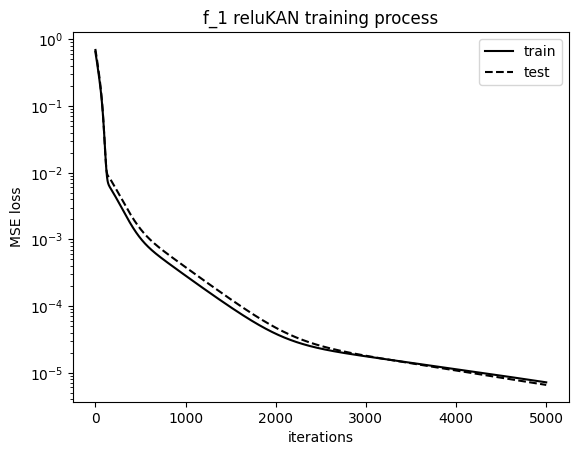

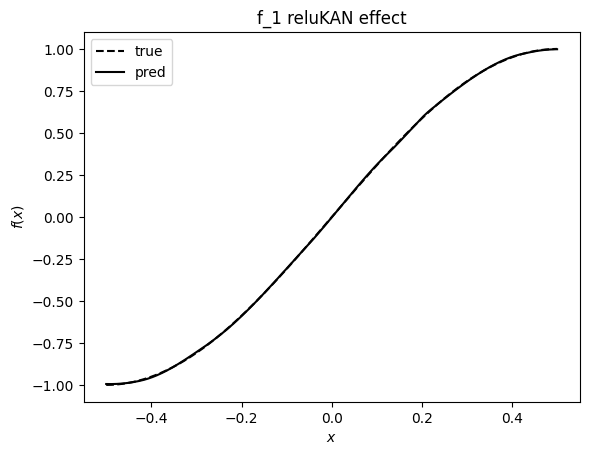

100%|██████████| 5000/5000 [00:05<00:00, 946.52it/s]


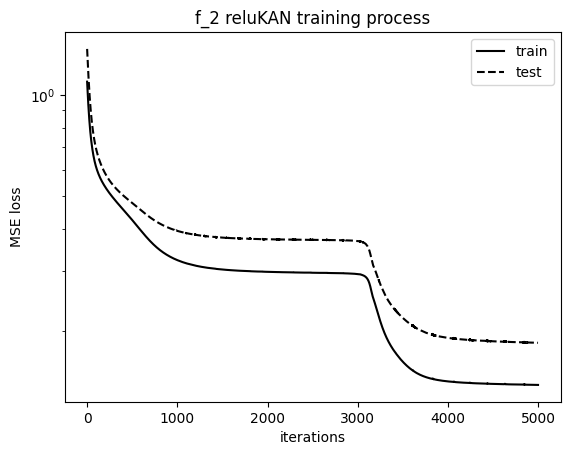

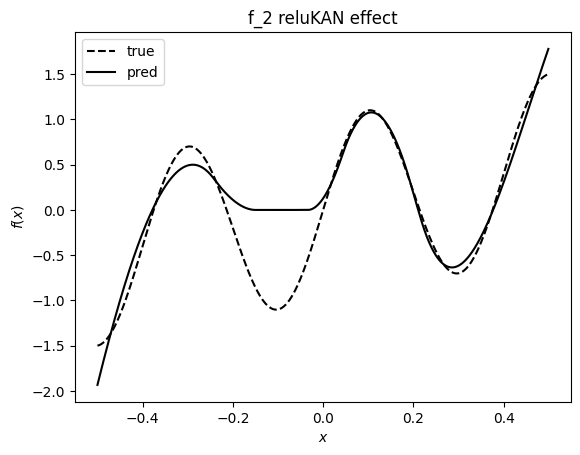

100%|██████████| 5000/5000 [00:11<00:00, 441.18it/s]


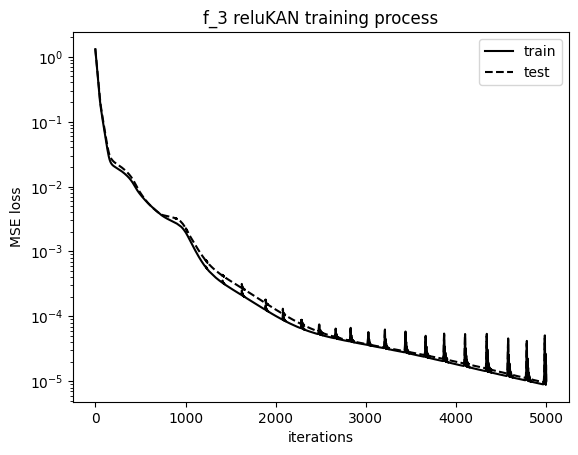

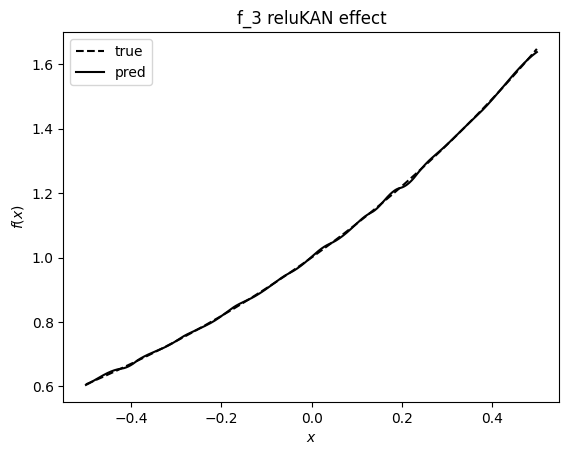

100%|██████████| 5000/5000 [00:21<00:00, 232.39it/s]


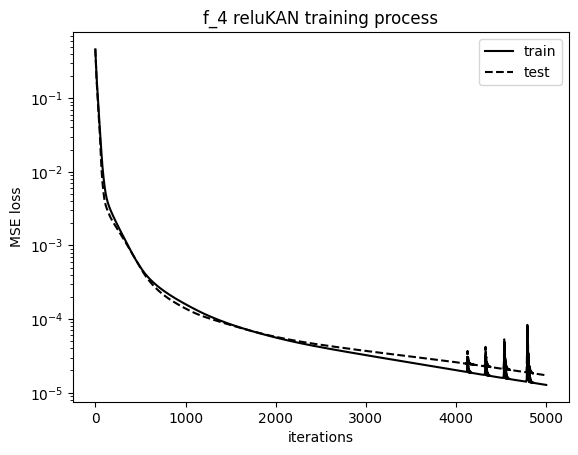

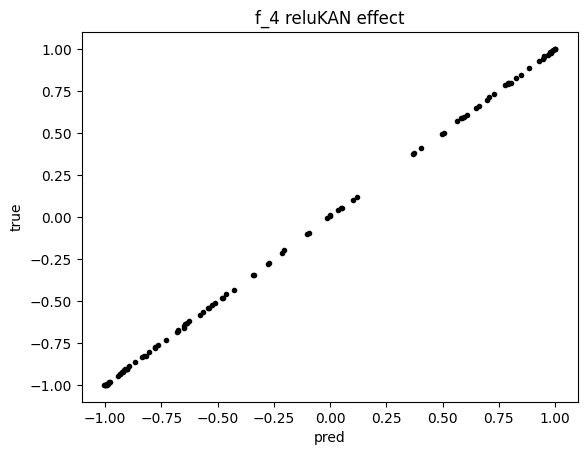

100%|██████████| 5000/5000 [00:23<00:00, 215.68it/s]


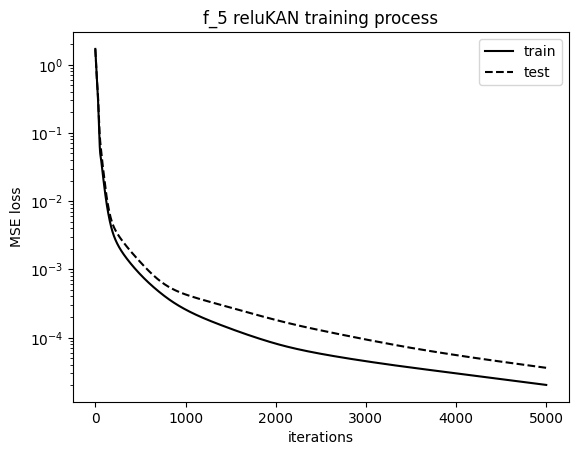

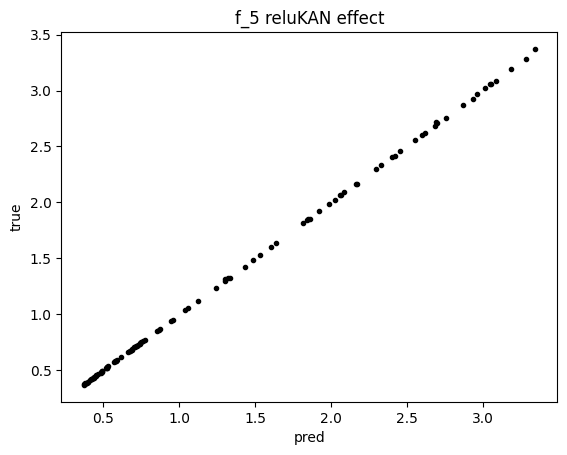

100%|██████████| 5000/5000 [00:28<00:00, 175.05it/s]


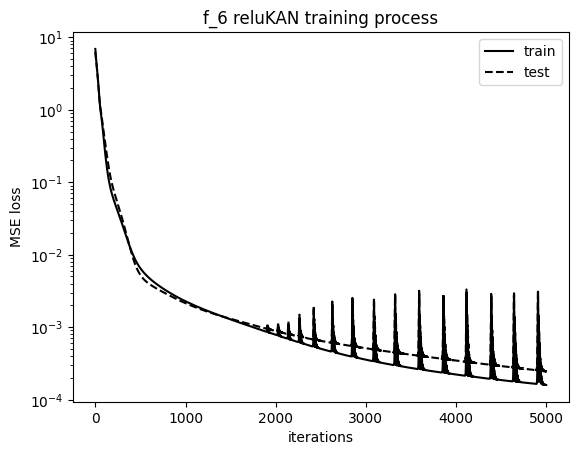

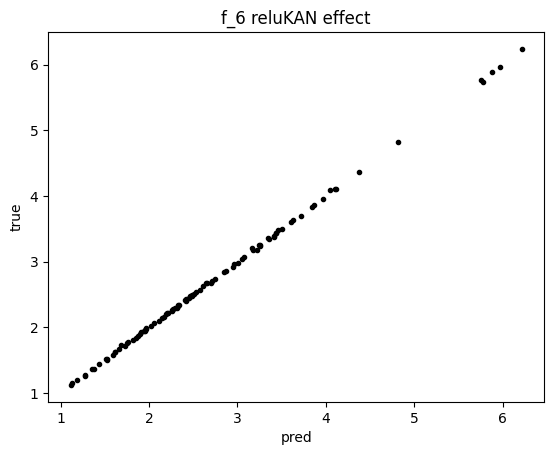

<Figure size 640x480 with 0 Axes>

In [283]:
train_plan = {
    'f_1 reluKAN': (f1, MultiLayerKAN(ReluKANLayer, [1, 1], 5, 3), 1),
    'f_2 reluKAN': (f7, MultiLayerKAN(ReluKANLayer, [1, 1], 5, 3), 1),
    'f_3 reluKAN': (f3, MultiLayerKAN(ReluKANLayer, [1, 2, 1], 5, 3), 1),
    'f_4 reluKAN': (f4, MultiLayerKAN(ReluKANLayer, [2, 5, 1], 5, 3), 2),
    'f_5 reluKAN': (f5, MultiLayerKAN(ReluKANLayer, [2, 5, 1], 5, 3), 2),
    'f_6 reluKAN': (f6, MultiLayerKAN(ReluKANLayer, [4, 5, 1], 5, 3), 4),
}

for f_name in train_plan:
    train = Train(*train_plan[f_name])
    train.train_process(5000)
    train.plt_loss(f_name)
    train.plt_fitting(f_name)
    train.save_process(f_name)

100%|██████████| 5000/5000 [00:04<00:00, 1140.79it/s]


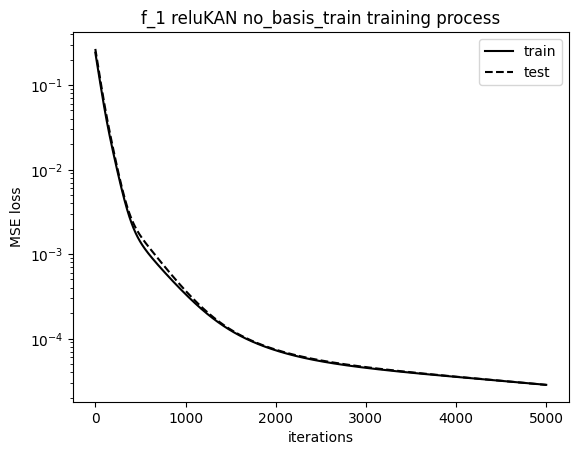

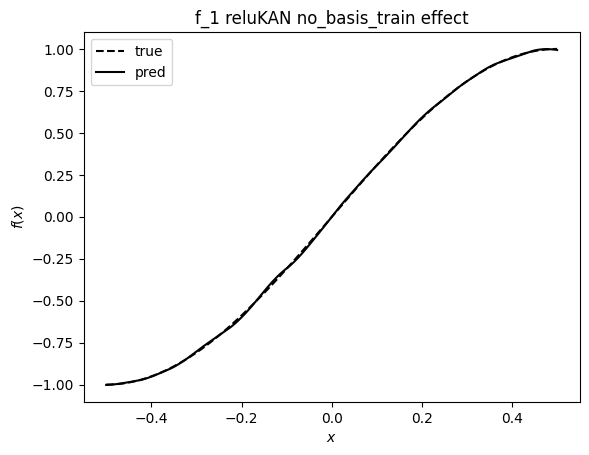

100%|██████████| 5000/5000 [00:04<00:00, 1139.51it/s]


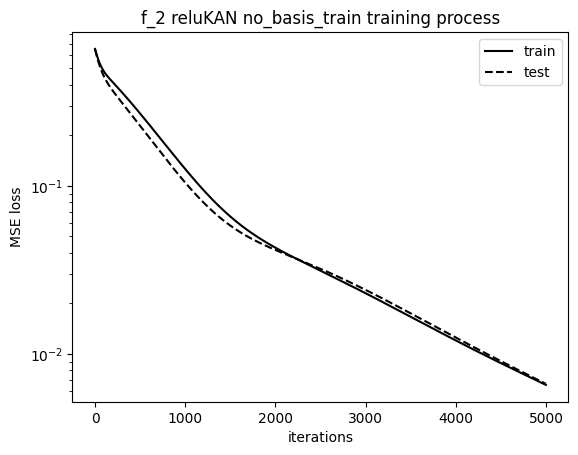

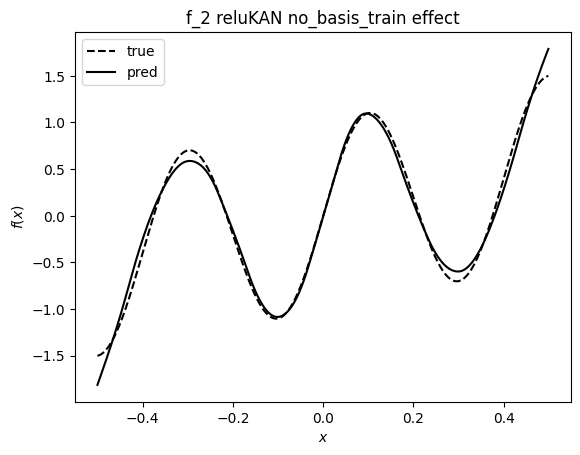

100%|██████████| 5000/5000 [00:12<00:00, 397.92it/s]


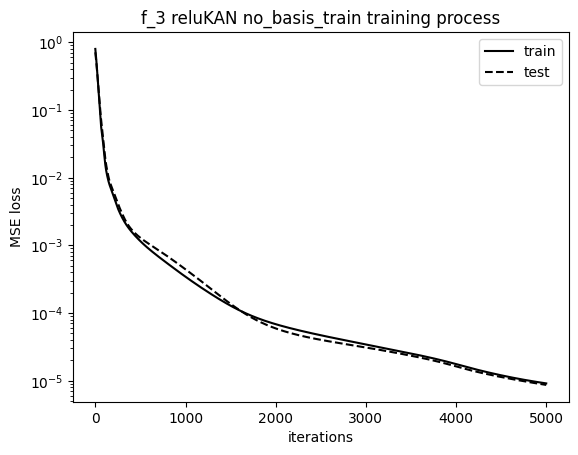

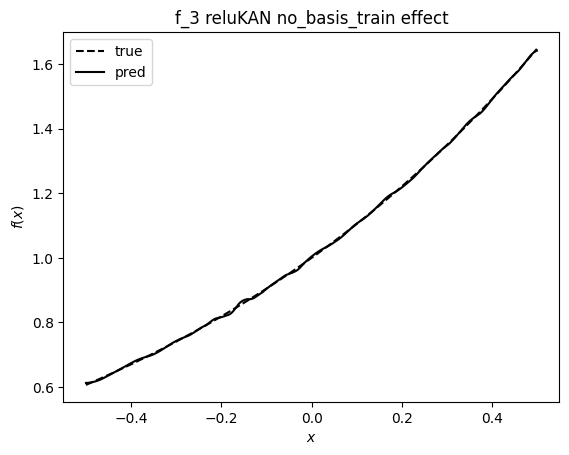

100%|██████████| 5000/5000 [00:25<00:00, 194.42it/s]


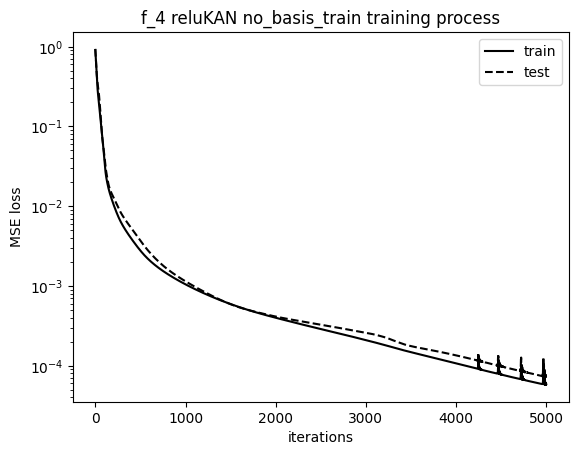

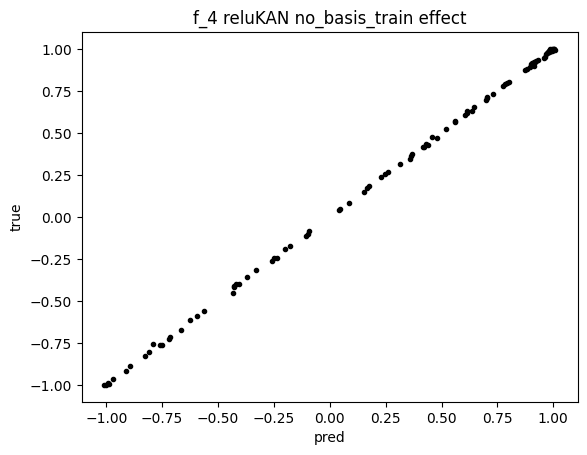

100%|██████████| 5000/5000 [00:22<00:00, 220.03it/s]


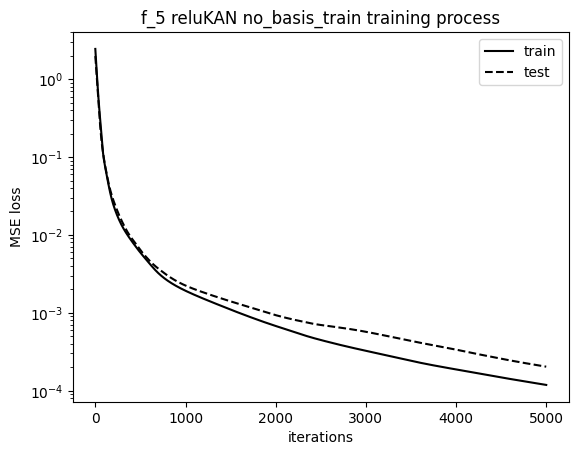

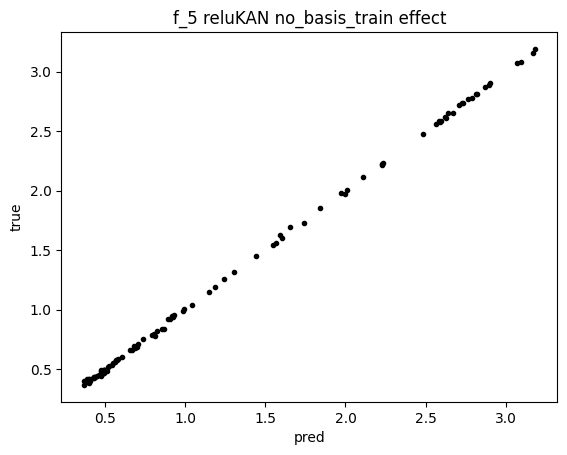

100%|██████████| 5000/5000 [00:29<00:00, 166.85it/s]


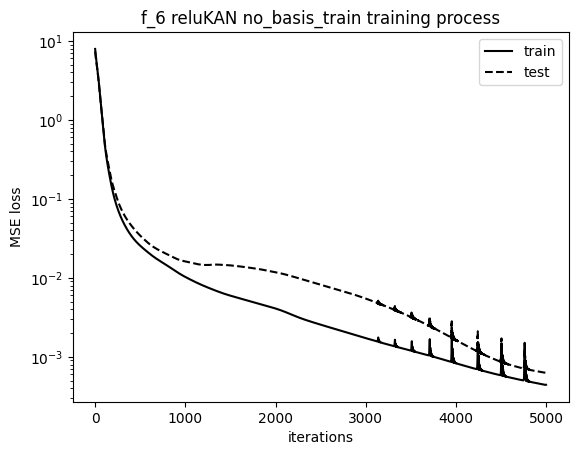

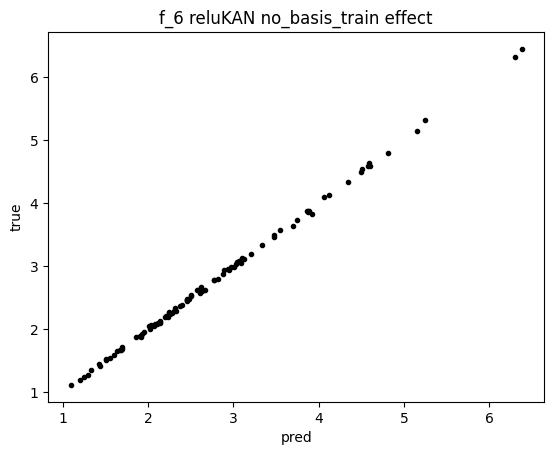

<Figure size 640x480 with 0 Axes>

In [284]:
multiplier = 3

train_plan = {
    'f_1 reluKAN no_basis_train': (f1, MultiLayerKAN(ReluKANLayer, [1, 1], multiplier*5, multiplier*3, kwargs_kan_layer={'train_ab':False}), 1),
    'f_2 reluKAN no_basis_train': (f7, MultiLayerKAN(ReluKANLayer, [1, 1], multiplier*5, multiplier*3, kwargs_kan_layer={'train_ab':False}), 1),
    'f_3 reluKAN no_basis_train': (f3, MultiLayerKAN(ReluKANLayer, [1, 2, 1], multiplier*5, multiplier*3, kwargs_kan_layer={'train_ab':False}), 1),
    'f_4 reluKAN no_basis_train': (f4, MultiLayerKAN(ReluKANLayer, [2, 5, 1], multiplier*5, multiplier*3, kwargs_kan_layer={'train_ab':False}), 2),
    'f_5 reluKAN no_basis_train': (f5, MultiLayerKAN(ReluKANLayer, [2, 5, 1], multiplier*5, multiplier*3, kwargs_kan_layer={'train_ab':False}), 2),
    'f_6 reluKAN no_basis_train': (f6, MultiLayerKAN(ReluKANLayer, [4, 5, 1], multiplier*5, multiplier*3, kwargs_kan_layer={'train_ab':False}), 4),
}

for f_name in train_plan:
    train = Train(*train_plan[f_name])
    train.train_process(5000)
    train.plt_loss(f_name)
    train.plt_fitting(f_name)
    train.save_process(f_name)